<h2 align = "center">Neural Network Implementation Basics</h2>

<h3> Importing packages</h3>

In [669]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
import matplotlib.pyplot as plt
torch.manual_seed(1)

<h3> Loading Files </h3>

In [670]:
positive_data = pd.read_fwf('../positive_sample.txt', header = None, nrows = 1000)
negative_data = pd.read_fwf('../negative_sample.txt', header = None, nrows = 1000)

<h3> Generating vocabulary </h3>

In [671]:
vocab_set = set()
window_size = 6
embeddings_size = 10
batch_size = 50
epochs = 1000
lr = 0.2
batch_size = 50
def generate_vocabmap_helper(set, k): 
    n = len(set)  
    generate_k_sized(set, "", n, k) 
def generate_k_sized(set, prefix, n, k): 
    if (k == 0) : 
        vocab_set.add(prefix)
        return
    for i in range(n): 
        newPrefix = prefix + set[i] 
        generate_k_sized(set, newPrefix, n, k - 1) 
def generate_vocabmap(n):
    alphabet = ['0','1','2','3','4']
    generate_vocabmap_helper(alphabet, n)
    
    vocab_set_1 = sorted(vocab_set)
    vocab_map = {}
    
    for i in range(len(vocab_set_1)):
        vocab_map[vocab_set_1[i]] = i
    return vocab_map

vocabulary = generate_vocabmap(window_size)

<h3> Generating Embeddings </h3>

In [672]:
#Embedding matrix for input and ouput
embeds = nn.Embedding(len(vocabulary), embeddings_size)
embeddings = {}
for word in vocabulary:
    embeddings[word] = embeds(torch.tensor(vocabulary[word], dtype=torch.long))

In [673]:
def generate_window_length_bases(data_sample):
    list_of_tensors = []
    for data in data_sample.itertuples():
        for i in range(len(data[1]) - window_size + 1):
            if i == 0:
                first_tensor = embeddings[data[1][i:i+window_size]]
            else:
                first_tensor = torch.cat((first_tensor, embeddings[data[1][i:i+window_size]]), 0)
        list_of_tensors.append(first_tensor)
    train = torch.stack(list_of_tensors)
    return train
positives = generate_window_length_bases(positive_data)
negatives = generate_window_length_bases(negative_data)
data_ = torch.cat([positives, negatives], dim=0)

negative_labels = torch.zeros(negatives.shape[0], 1)
positive_labels = torch.ones(positives.shape[0], 1)
labels_ = torch.cat([positive_labels, negative_labels], dim=0)

In [674]:
positives.shape

torch.Size([1000, 960])

<h3> Neural Network </h3>

In [675]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(embeddings_size * (len(positive_data[0][0]) - window_size + 1), 505)
        self.relu1 = nn.Sigmoid()
        self.fc2 = nn.Linear(505, 100)
        self.prelu = nn.ReLU()
        self.out = nn.Linear(100, 1)
        self.out_act = nn.Sigmoid()

    def forward(self, x):
        a1 = self.fc1(x)
        h1 = self.relu1(a1)
        a2 = self.fc2(h1)
        h2 = self.prelu(a2)
        a3 = self.out(h2)
        y = self.out_act(a3)
        return y
net = Net()

<h3> Optimization and Loss Calculation </h3>

In [676]:
opt = optim.SGD(net.parameters(), lr=0.01, momentum = 0.0)
criterion = nn.BCELoss()

<h3> Training and Saving the Model </h3>

In [677]:
def train_epoch(model, opt, criterion, batch_size):
    model.train()
    losses = []
    for i in range(0, data_.size(0), batch_size):
        data_batch = data_[i:i + batch_size, :]
        labels_batch = labels_[i:i + batch_size, :]
        data_batch = autograd.Variable(data_batch)
        labels_batch = autograd.Variable(labels_batch)

        opt.zero_grad()
        labels_hat = net(data_batch)
        loss = criterion(labels_hat, labels_batch)
        loss.backward()
        opt.step()        
        losses.append(loss.data.numpy())
    loss = sum(losses)/len(losses)
    return loss

Average Loss at  0  steps:  0.5894961219280959
Average Loss at  100  steps:  0.6495128765702247
Average Loss at  200  steps:  0.15780695518478752
Average Loss at  300  steps:  0.09607502706348896
Average Loss at  400  steps:  0.03607096765190363
Average Loss at  500  steps:  0.004065680006169714
Average Loss at  600  steps:  0.001988223896478303
Average Loss at  700  steps:  0.0013413741733529605
Average Loss at  800  steps:  0.0010052565252408386
Average Loss at  900  steps:  0.0008018531159905251


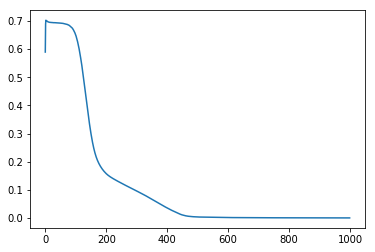

In [678]:
losses = []

for e in range(epochs):
    loss = train_epoch(net, opt, criterion, batch_size)
    losses.append(loss)
    if(e%100 == 0):
            print("Average Loss at ", e, " steps: ", loss)
torch.save(net.state_dict(), 'model.py')
plt.plot(losses)

<h3> Loading Model for making predictions </h3>

In [679]:
model = Net()
model.load_state_dict(torch.load('model.py'))
model.eval()

Net(
  (fc1): Linear(in_features=960, out_features=505, bias=True)
  (relu1): Sigmoid()
  (fc2): Linear(in_features=505, out_features=100, bias=True)
  (prelu): ReLU()
  (out): Linear(in_features=100, out_features=1, bias=True)
  (out_act): Sigmoid()
)

<h3> Loading Test data and making predictions </h3>

In [680]:
positive_test_data = pd.read_fwf('../positive_sample_test.txt', header = None)
negative_test_data = pd.read_fwf('../negative_sample_test.txt', header = None)

In [681]:
positive_test_data.shape

(100, 1)

In [682]:
positives_test = generate_window_length_bases(positive_test_data)
negatives_test = generate_window_length_bases(negative_test_data)

data_test = torch.cat([positives_test, negatives_test], dim=0)

negative_labels_test = torch.zeros(negatives_test.shape[0], 1)
positive_labels_test = torch.ones(positives_test.shape[0], 1)
labels_test = torch.cat([positive_labels_test, negative_labels_test], dim=0)

In [683]:
labels_hat = model(data_test)

In [684]:
labels_hat.shape

torch.Size([200, 1])

In [685]:
correct, wrong = 0, 0
for i in range(labels_hat.shape[0]//2 + 1):
    if labels_hat[i] > 0.5:
        correct += 1
    else:
        wrong += 1
for i in range(101, labels_hat.shape[0]):
    if labels_hat[i] > 0.5:
        wrong += 1
    else:
        correct += 1
print("Accuracy = ", (correct * 100)/(correct + wrong),"%")

Accuracy =  60.5 %
